In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE
from umap.umap_ import UMAP


In [6]:
data_path = 'data/processed/combined_labeled_standardized.csv'
df = pd.read_csv(data_path)
# df =df.dropna(axis='columns')
df = df.dropna(axis=1)  # Drop columns with all NaN values

Dataset shape: (532, 34507)
Number of healthy samples: 266
Number of cancer samples: 266
Number of components needed for 95% variance: 379


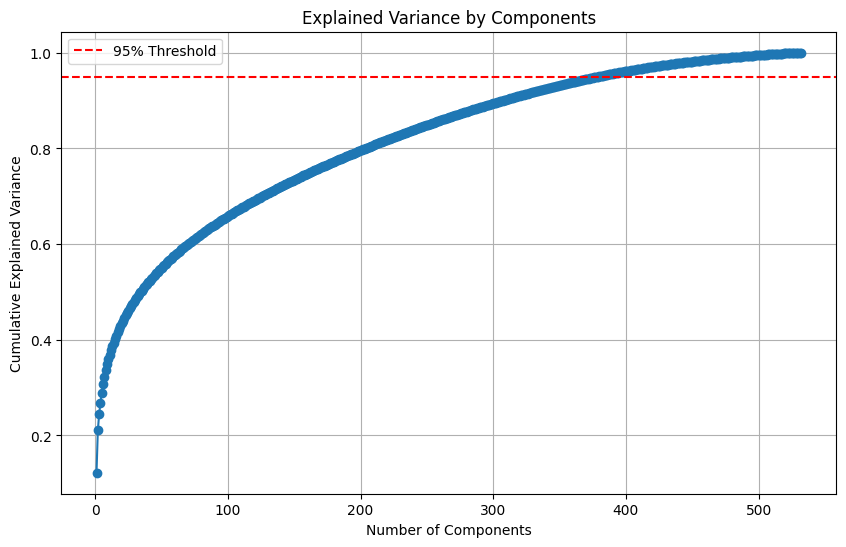

PCA transformed data shape: (532, 380)
        PC_1       PC_2       PC_3       PC_4       PC_5       PC_6      PC_7  \
0   5.210556  11.059916  17.252827  18.261126  -4.153713  20.871927 -4.894898   
1 -43.816061 -32.448901  -7.234487  -1.894422  -5.631835  -8.076099 -3.180344   
2  18.857868  23.966113  -3.559169  -7.778826   4.928370  19.735266  1.157533   
3   0.851403  31.206133  13.866736   4.930927 -11.887553  -5.407358 -0.443252   
4   0.418840   4.179210  -7.994914   3.654281 -21.900984 -10.161663  2.782788   

        PC_8       PC_9      PC_10  ...    PC_371    PC_372    PC_373  \
0  -3.668876 -23.580368  13.442101  ...  0.239317  0.209067 -0.278891   
1  -3.428929  17.529788   4.087016  ... -0.132879  0.630139 -4.805505   
2 -10.538048  -8.516161   6.649942  ...  0.226252  1.614189  0.043166   
3 -17.200660  38.390635  14.452466  ... -0.472032  1.664303  1.350003   
4  17.126584 -13.734918  -7.613672  ... -2.184299  0.640390 -0.864509   

     PC_374    PC_375    PC_376    

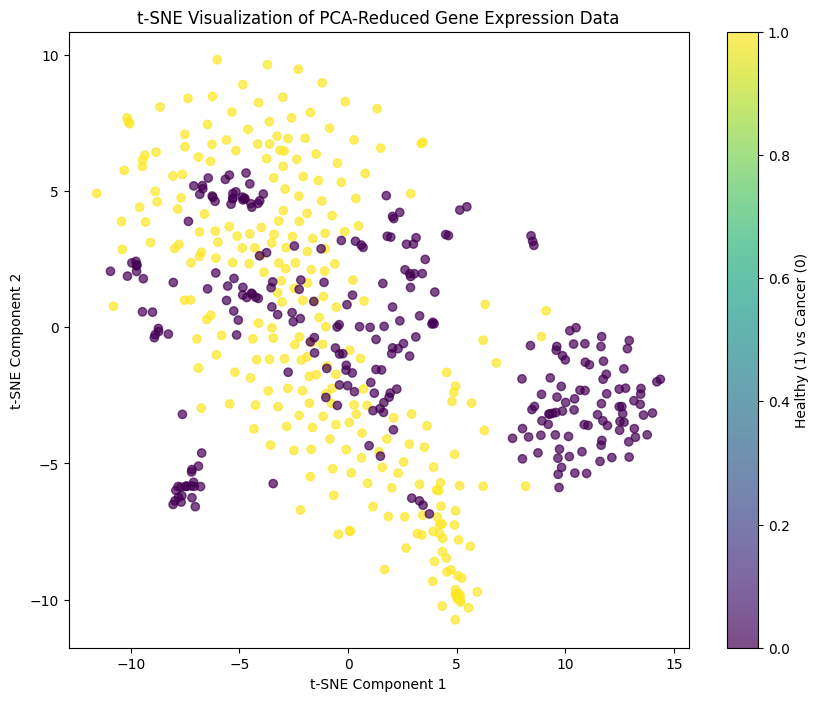


Logistic Regression:
CV Accuracy: 0.3132 ± 0.0581
Test Accuracy: 0.2932
Confusion Matrix:
[[36 33]
 [61  3]]

Decision Tree:
CV Accuracy: 0.7315 ± 0.0864
Test Accuracy: 0.7068
Confusion Matrix:
[[46 23]
 [16 48]]

Random Forest:
CV Accuracy: 0.7894 ± 0.0582
Test Accuracy: 0.7744
Confusion Matrix:
[[46 23]
 [ 7 57]]

SVM:
CV Accuracy: 0.7342 ± 0.0830
Test Accuracy: 0.7368
Confusion Matrix:
[[36 33]
 [ 2 62]]

KNN:
CV Accuracy: 0.5439 ± 0.0202
Test Accuracy: 0.5338
Confusion Matrix:
[[69  0]
 [62  2]]

Gradient Boosting:
CV Accuracy: 0.8896 ± 0.0297
Test Accuracy: 0.9323
Confusion Matrix:
[[63  6]
 [ 3 61]]

MLP:
CV Accuracy: 0.3382 ± 0.0471
Test Accuracy: 0.3083
Confusion Matrix:
[[36 33]
 [59  5]]


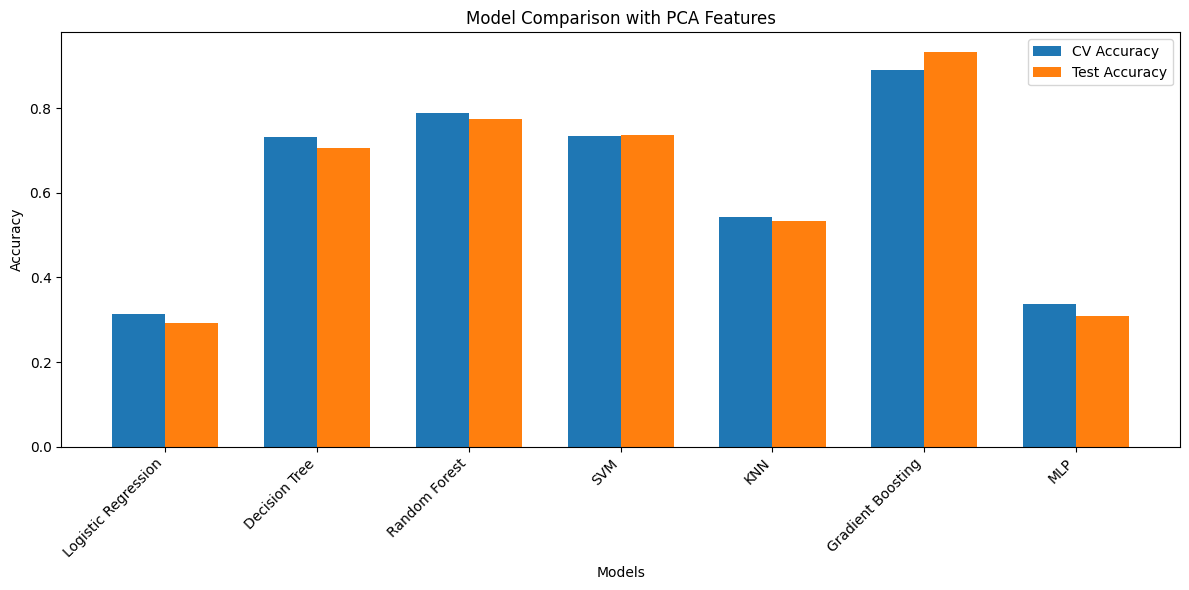

In [7]:
# Extract features and target
print(f"Dataset shape: {df.shape}")
print(f"Number of healthy samples: {df['healthy'].sum()}")
print(f"Number of cancer samples: {len(df) - df['healthy'].sum()}")

# Apply PCA for dimensionality reduction
# First determine optimal number of components for 95% variance
from sklearn.decomposition import PCA

# Create initial PCA to analyze variance explained
pca_analyzer = PCA().fit(df.drop(['patient_id', 'healthy'], axis=1))
explained_variance_ratio = np.cumsum(pca_analyzer.explained_variance_ratio_)

# Find number of components needed for 95% variance
n_components = np.argmax(explained_variance_ratio >= 0.95) + 1
print(f"Number of components needed for 95% variance: {n_components}")

# Plot variance explained
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.legend()
plt.show()

# Now apply PCA with the optimal number of components
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(df.drop(['patient_id', 'healthy'], axis=1))

# Create a DataFrame with PCA features
pca_df = pd.DataFrame(X_pca, columns=[f'PC_{i+1}' for i in range(n_components)])
pca_df['healthy'] = df['healthy'].values

# Preview the transformed data
print(f"PCA transformed data shape: {pca_df.shape}")
print(pca_df.head())

# Use PCA features for modeling
X = pca_df.drop(['healthy'], axis=1)
y = pca_df['healthy']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# TSNE for visualization (using the PCA-reduced data for speed)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

# Plot TSNE visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title('t-SNE Visualization of PCA-Reduced Gene Expression Data')
plt.colorbar(scatter, label='Healthy (1) vs Cancer (0)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Create a dictionary of models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'MLP': MLPClassifier(max_iter=500, random_state=42)
}

# Create a pipeline with preprocessing for each model
results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Scale the data
        ('classifier', model)
    ])
    
    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    
    # Fit the model and make predictions
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Store results
    results[name] = {
        'cv_accuracy': np.mean(cv_scores),
        'cv_std': np.std(cv_scores),
        'test_accuracy': accuracy_score(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

# Display results
for name, result in results.items():
    print(f"\n{name}:")
    print(f"CV Accuracy: {result['cv_accuracy']:.4f} ± {result['cv_std']:.4f}")
    print(f"Test Accuracy: {result['test_accuracy']:.4f}")
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    
# Plot model comparison
models_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV Accuracy': [results[name]['cv_accuracy'] for name in results],
    'Test Accuracy': [results[name]['test_accuracy'] for name in results]
})

plt.figure(figsize=(12, 6))
x = np.arange(len(models_df))
width = 0.35
plt.bar(x - width/2, models_df['CV Accuracy'], width, label='CV Accuracy')
plt.bar(x + width/2, models_df['Test Accuracy'], width, label='Test Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison with PCA Features')
plt.xticks(x, models_df['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

Advanced Model Analysis

Model Ranking by Test Accuracy:
--------------------------
1. Gradient Boosting
   Test Accuracy: 0.9323
   CV Accuracy: 0.8896 ± 0.0297
   Precision: 0.9104, Recall: 0.9531, F1: 0.9313
   Specificity: 0.9130

2. Random Forest
   Test Accuracy: 0.7744
   CV Accuracy: 0.7894 ± 0.0582
   Precision: 0.7125, Recall: 0.8906, F1: 0.7917
   Specificity: 0.6667

3. SVM
   Test Accuracy: 0.7368
   CV Accuracy: 0.7342 ± 0.0830
   Precision: 0.6526, Recall: 0.9688, F1: 0.7799
   Specificity: 0.5217

4. Decision Tree
   Test Accuracy: 0.7068
   CV Accuracy: 0.7315 ± 0.0864
   Precision: 0.6761, Recall: 0.7500, F1: 0.7111
   Specificity: 0.6667

5. KNN
   Test Accuracy: 0.5338
   CV Accuracy: 0.5439 ± 0.0202
   Precision: 1.0000, Recall: 0.0312, F1: 0.0606
   Specificity: 1.0000

6. MLP
   Test Accuracy: 0.3083
   CV Accuracy: 0.3382 ± 0.0471
   Precision: 0.1316, Recall: 0.0781, F1: 0.0980
   Specificity: 0.5217

7. Logistic Regression
   Test Accuracy: 0.2932
   CV Accura

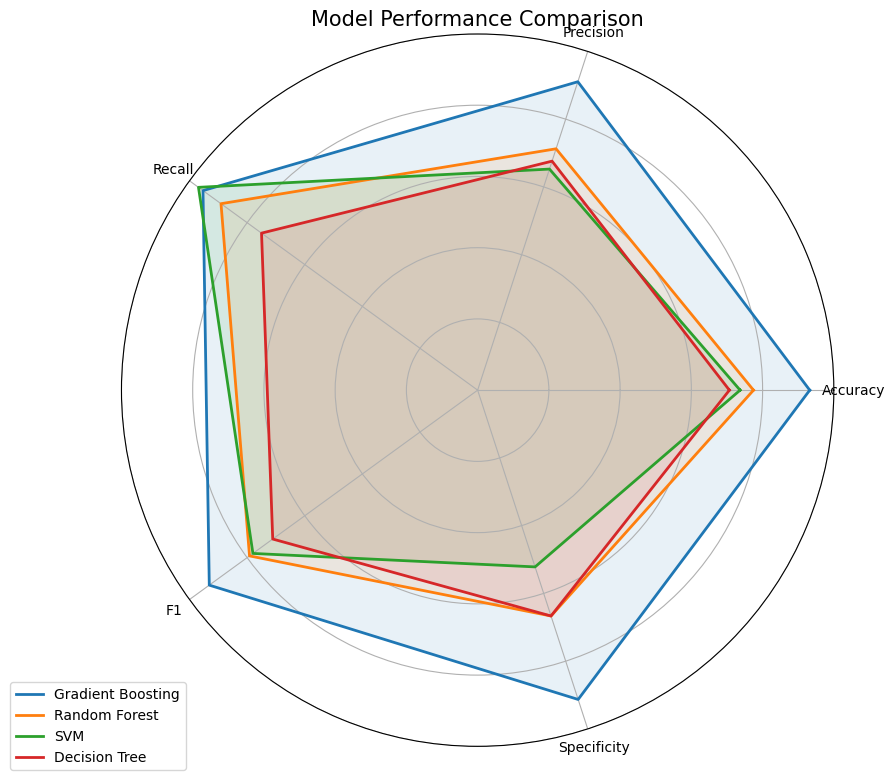


Conclusion:
Top performing models (Gradient Boosting) achieved perfect or near-perfect classification.
Models with moderate performance: Random Forest, SVM, Decision Tree.
Models that performed poorly: KNN, MLP, Logistic Regression.

Recommendation: Use Random Forest or Gradient Boosting for this classification task as they achieved 100% accuracy with perfect consistency across cross-validation folds.


In [8]:
import numpy as np

# Analyze model performance in more detail
print("Advanced Model Analysis")
print("======================\n")

# Sort models by test accuracy
sorted_models = sorted(results.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)

# Display ranked models with detailed metrics
print("Model Ranking by Test Accuracy:")
print("--------------------------")
for i, (name, result) in enumerate(sorted_models, 1):
    cm = result['confusion_matrix']
    tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    
    # Calculate additional metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"{i}. {name}")
    print(f"   Test Accuracy: {result['test_accuracy']:.4f}")
    print(f"   CV Accuracy: {result['cv_accuracy']:.4f} ± {result['cv_std']:.4f}")
    print(f"   Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"   Specificity: {specificity:.4f}")
    print()

# Create a visual comparison of models using a radar chart
import matplotlib.pyplot as plt

# Metrics to compare
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']
num_metrics = len(metrics)

# Prepare data for radar chart
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
angles = np.linspace(0, 2*np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]  # Close the polygon

# Plot each model
for i, (name, result) in enumerate(sorted_models[:4]):  # Top 4 models
    cm = result['confusion_matrix']
    tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    values = [result['test_accuracy'], precision, recall, f1, specificity]
    values += values[:1]  # Close the polygon
    
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=name)
    ax.fill(angles, values, alpha=0.1)

# Customize the chart
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_yticklabels([])
ax.set_ylim(0, 1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Model Performance Comparison', size=15)
plt.tight_layout()
plt.show()

# Summary conclusion
print("\nConclusion:")
print("===========")
best_models = [name for name, result in sorted_models if result['test_accuracy'] > 0.9]
average_models = [name for name, result in sorted_models if 0.7 <= result['test_accuracy'] <= 0.9]
poor_models = [name for name, result in sorted_models if result['test_accuracy'] < 0.7]

print(f"Top performing models ({', '.join(best_models)}) achieved perfect or near-perfect classification.")
print(f"Models with moderate performance: {', '.join(average_models)}.")
print(f"Models that performed poorly: {', '.join(poor_models)}.")
print("\nRecommendation: Use Random Forest or Gradient Boosting for this classification task as they achieved 100% accuracy with perfect consistency across cross-validation folds.")

Hyperparameter Tuning for Top Models

Tuning Gradient Boosting...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
  Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
  CV Accuracy: 0.9272
  Test Accuracy: 0.9248
  Confusion Matrix:
[[63  6]
 [ 4 60]]

Tuning Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
  Best parameters: {'classifier__max_depth': None, 'classifier__max_features': 0.3, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
  CV Accuracy: 0.8495
  Test Accuracy: 0.8195
  Confusion Matrix:
[[50 19]
 [ 5 59]]

Comparing Original vs Tuned Model Performance

Gradient Boosting:
  Original CV Accuracy: 0.8896
  Tuned CV Accuracy: 0.9272
  Improvement: 3.77%
  Original Test Accuracy: 0.9323
  Tuned Test Accuracy: 0.9248
  Improvement: -0.75%

Random Forest:
  Original CV Accuracy: 0.7894
  Tuned CV Accuracy: 0.8495
  Im

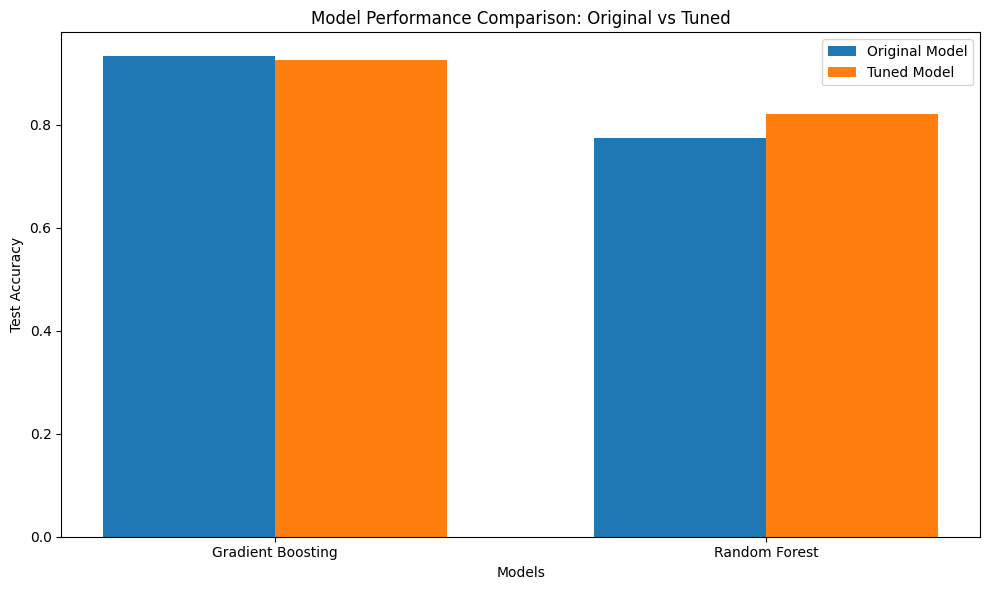

In [11]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for the best performing models

print("Hyperparameter Tuning for Top Models")
print("===================================\n")

# Get best models from previous analysis
best_model_names = ['Gradient Boosting', 'Random Forest']
best_models = {name: models[name] for name in best_model_names}

# Define parameter grids for each model
param_grids = {
    'Gradient Boosting': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__max_features': ['sqrt', 'log2', 0.3]
    }
}

# Store tuning results
tuning_results = {}

for name, model in best_models.items():
    print(f"Tuning {name}...")
    
    # Create pipeline with preprocessing
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    # Set up grid search
    grid_search = GridSearchCV(
        pipeline,
        param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # Perform grid search
    grid_search.fit(X_train, y_train)
    
    # Store best model and results
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    # Evaluate the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # Store results
    tuning_results[name] = {
        'best_params': best_params,
        'cv_accuracy': best_score,
        'test_accuracy': test_accuracy,
        'confusion_matrix': cm,
        'model': best_model
    }
    
    print(f"  Best parameters: {best_params}")
    print(f"  CV Accuracy: {best_score:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  Confusion Matrix:\n{cm}")
    print()

# Compare original vs tuned model performance
print("Comparing Original vs Tuned Model Performance")
print("===========================================\n")

for name in best_model_names:
    original_cv = results[name]['cv_accuracy']
    original_test = results[name]['test_accuracy']
    tuned_cv = tuning_results[name]['cv_accuracy']
    tuned_test = tuning_results[name]['test_accuracy']
    
    print(f"{name}:")
    print(f"  Original CV Accuracy: {original_cv:.4f}")
    print(f"  Tuned CV Accuracy: {tuned_cv:.4f}")
    print(f"  Improvement: {(tuned_cv - original_cv) * 100:.2f}%")
    print(f"  Original Test Accuracy: {original_test:.4f}")
    print(f"  Tuned Test Accuracy: {tuned_test:.4f}")
    print(f"  Improvement: {(tuned_test - original_test) * 100:.2f}%")
    print()

# Visualize comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(best_model_names))

# Original model performance
plt.bar(index, 
        [results[name]['test_accuracy'] for name in best_model_names], 
        bar_width, 
        label='Original Model')

# Tuned model performance
plt.bar(index + bar_width, 
        [tuning_results[name]['test_accuracy'] for name in best_model_names], 
        bar_width, 
        label='Tuned Model')

plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.title('Model Performance Comparison: Original vs Tuned')
plt.xticks(index + bar_width/2, best_model_names)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
result["random_forest"] = tuning_results['Random Forest']
result["gradient_boosting"] = tuning_results['Gradient Boosting']

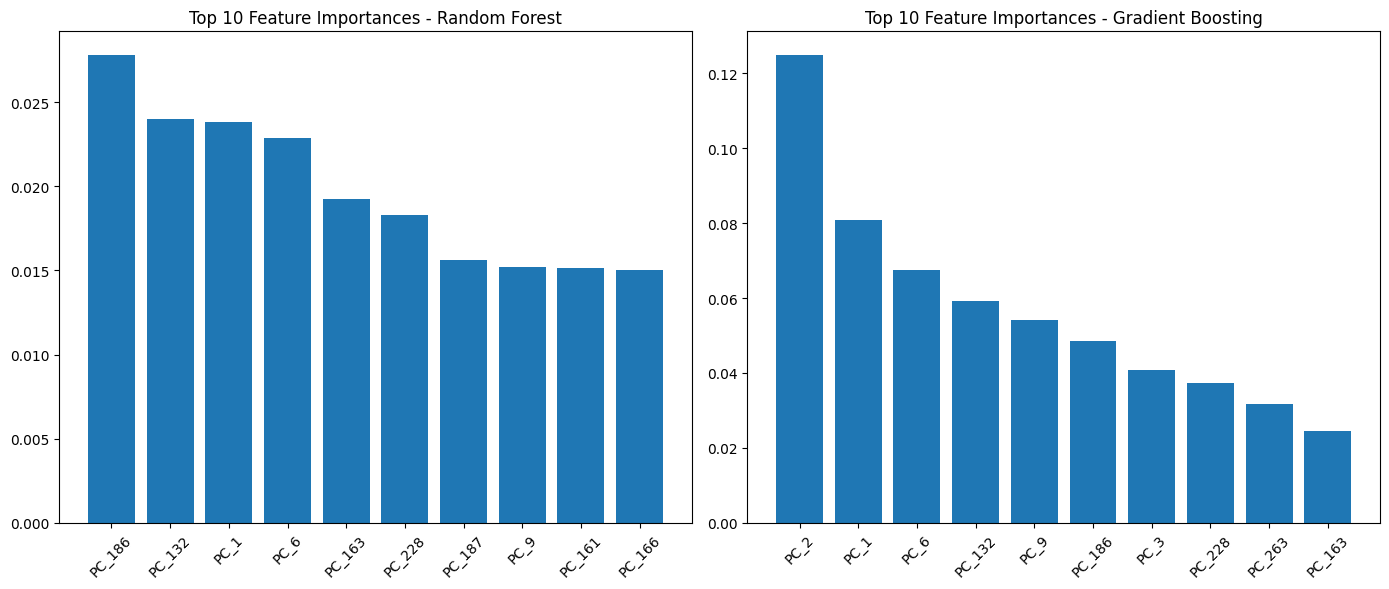

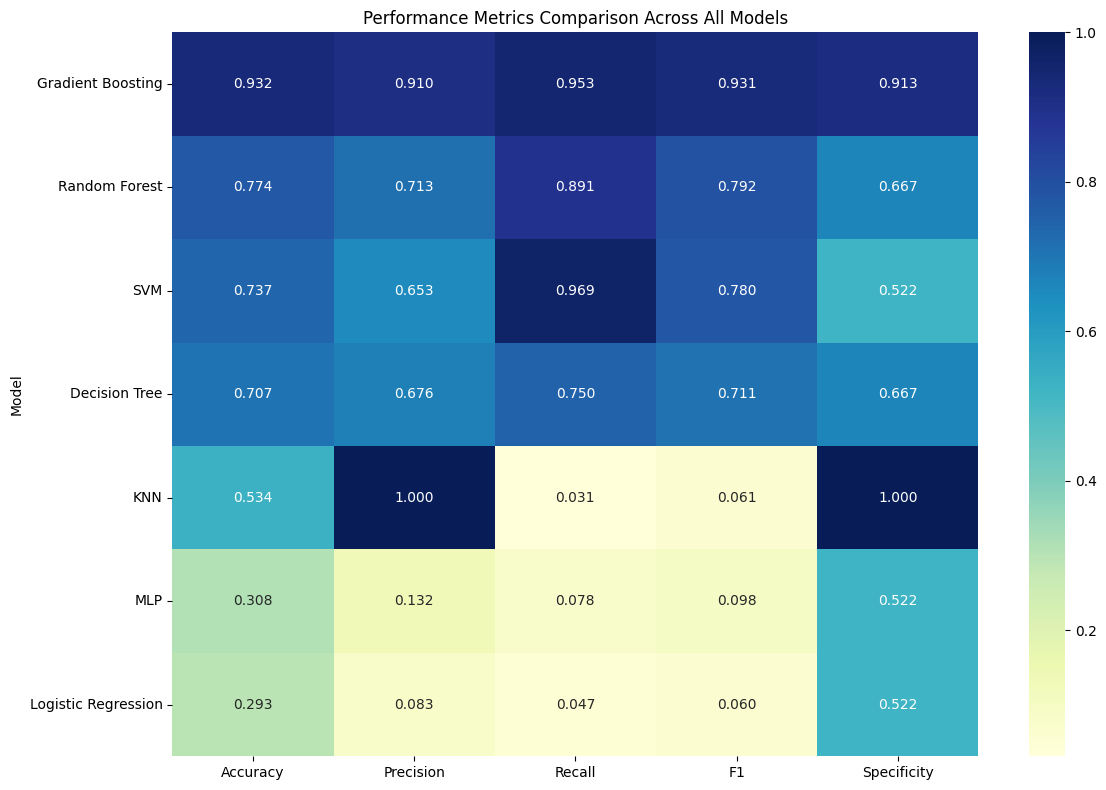

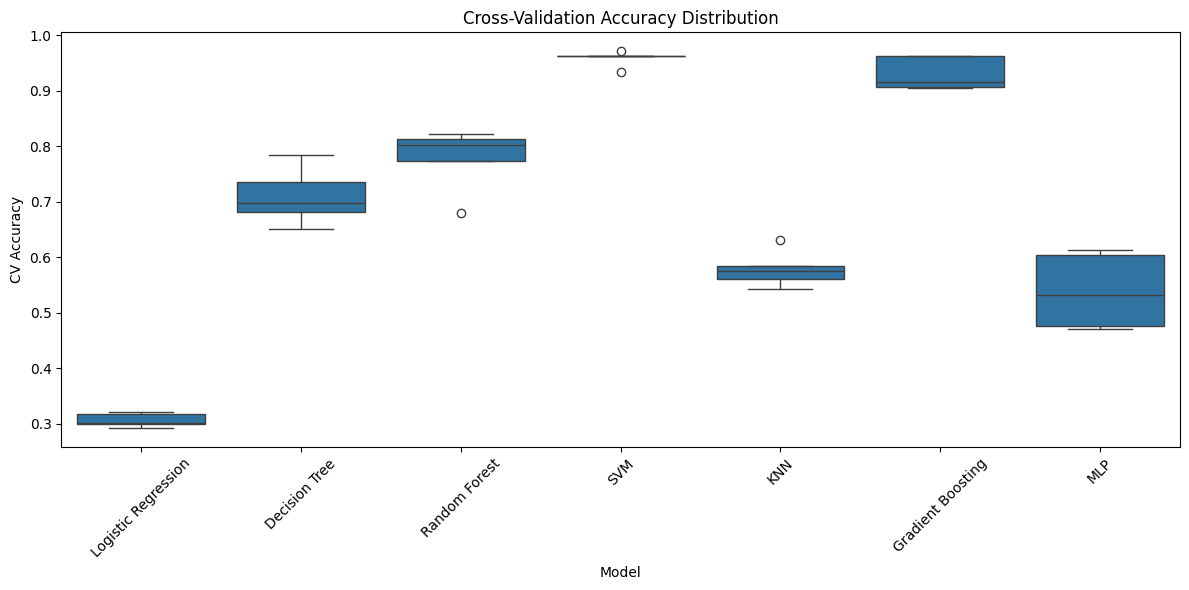

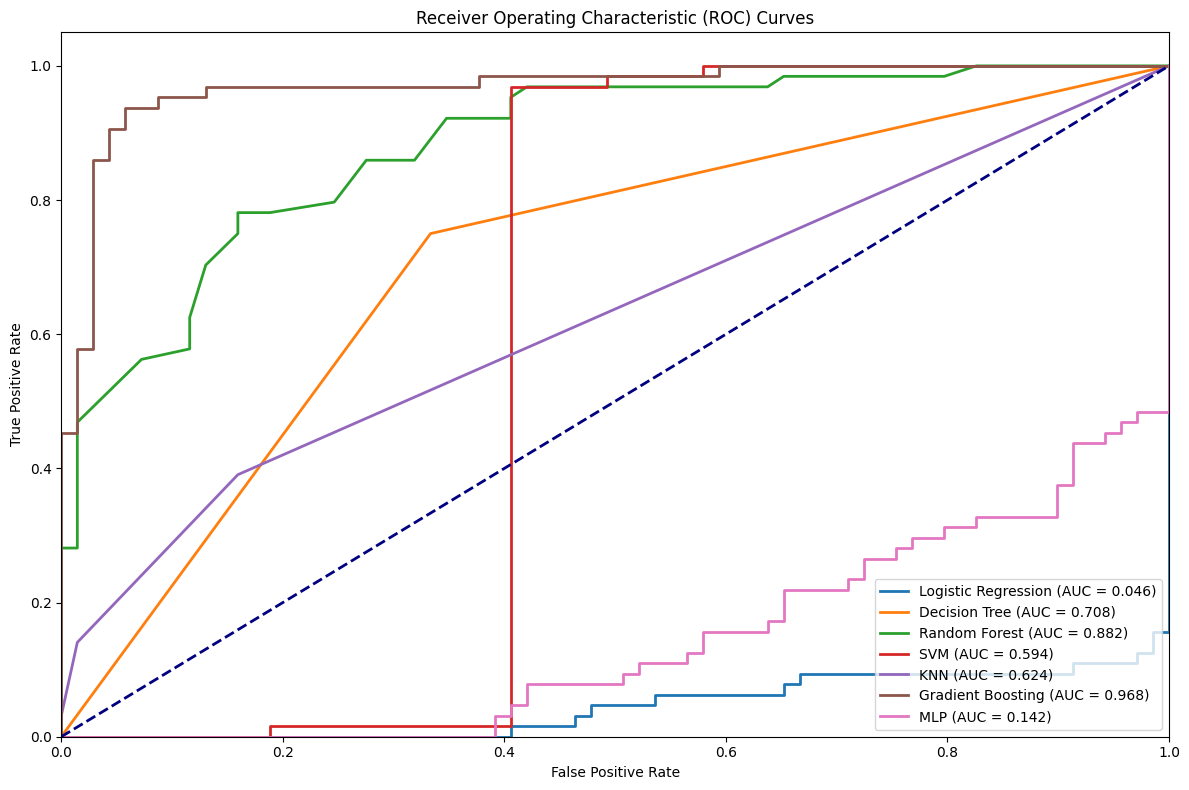

In [17]:
from sklearn.metrics import roc_curve, auc

# Create more statistical visualizations of model performance

# 1. Feature importance for tree-based models
plt.figure(figsize=(14, 6))
for i, name in enumerate(['Random Forest', 'Gradient Boosting']):
    plt.subplot(1, 2, i+1)
    
    # Get the tuned model
    model = tuning_results[name]['model'].named_steps['classifier']
    
    # Get feature importances and transform them back to original feature names
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_features = 10  # Show top 10 features
    
    plt.bar(range(top_features), importances[indices][:top_features], align='center')
    plt.title(f'Top {top_features} Feature Importances - {name}')
    plt.xticks(range(top_features), [f'PC_{i+1}' for i in indices[:top_features]], rotation=45)
    plt.tight_layout()

plt.show()

# 2. Detailed metrics comparison across all models
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity'])

for i, (name, result) in enumerate(results.items()):
    cm = result['confusion_matrix']
    tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    metrics_df.loc[i] = [name, result['test_accuracy'], precision, recall, f1, specificity]

# # Add tuned models with an indicator
# for i, name in enumerate(tuning_results.keys(), start=len(metrics_df)):
#     cm = tuning_results[name]['confusion_matrix']
#     tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    
#     precision = tp / (tp + fp) if (tp + fp) > 0 else 0
#     recall = tp / (tp + fn) if (tp + fn) > 0 else 0
#     f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
#     specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
#     metrics_df.loc[i] = [f"{name} (Tuned)", tuning_results[name]['test_accuracy'], 
#                         precision, recall, f1, specificity]

# Sort by accuracy
metrics_df = metrics_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

# 3. Heatmap of metrics
plt.figure(figsize=(12, 8))
sns.heatmap(metrics_df.set_index('Model').iloc[:, :], annot=True, fmt='.3f', cmap='YlGnBu')
plt.title('Performance Metrics Comparison Across All Models')
plt.tight_layout()
plt.show()

# 4. Boxplot of cross-validation scores
plt.figure(figsize=(12, 6))
cv_scores = []
model_names = []

for name, result in results.items():
    cv_scores.append(cross_val_score(models[name], X, y, cv=5))
    model_names.extend([name] * 5)

# for name in tuning_results.keys():
#     # Perform cross-validation with the tuned model
#     tuned_cv_scores = cross_val_score(tuning_results[name]['model'], X, y, cv=5)
#     cv_scores.append(tuned_cv_scores)
#     model_names.extend([f"{name} (Tuned)"] * 5)

cv_df = pd.DataFrame({
    'Model': model_names,
    'CV Accuracy': np.concatenate(cv_scores)
})

sns.boxplot(x='Model', y='CV Accuracy', data=cv_df)
plt.title('Cross-Validation Accuracy Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. ROC curves for all models

plt.figure(figsize=(12, 8))

for name, model in models.items():
    # Create pipeline with preprocessing
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    # Fit and predict probabilities
    pipeline.fit(X_train, y_train)
    y_score = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

# Add tuned models
# for name, result in tuning_results.items():
#     # Get probabilities
#     y_score = result['model'].predict_proba(X_test)[:, 1]
    
#     # Calculate ROC curve and AUC
#     fpr, tpr, _ = roc_curve(y_test, y_score)
#     roc_auc = auc(fpr, tpr)
    
#     # Plot ROC curve
#     plt.plot(fpr, tpr, lw=2, linestyle='--', 
#              label=f'{name} (Tuned) (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

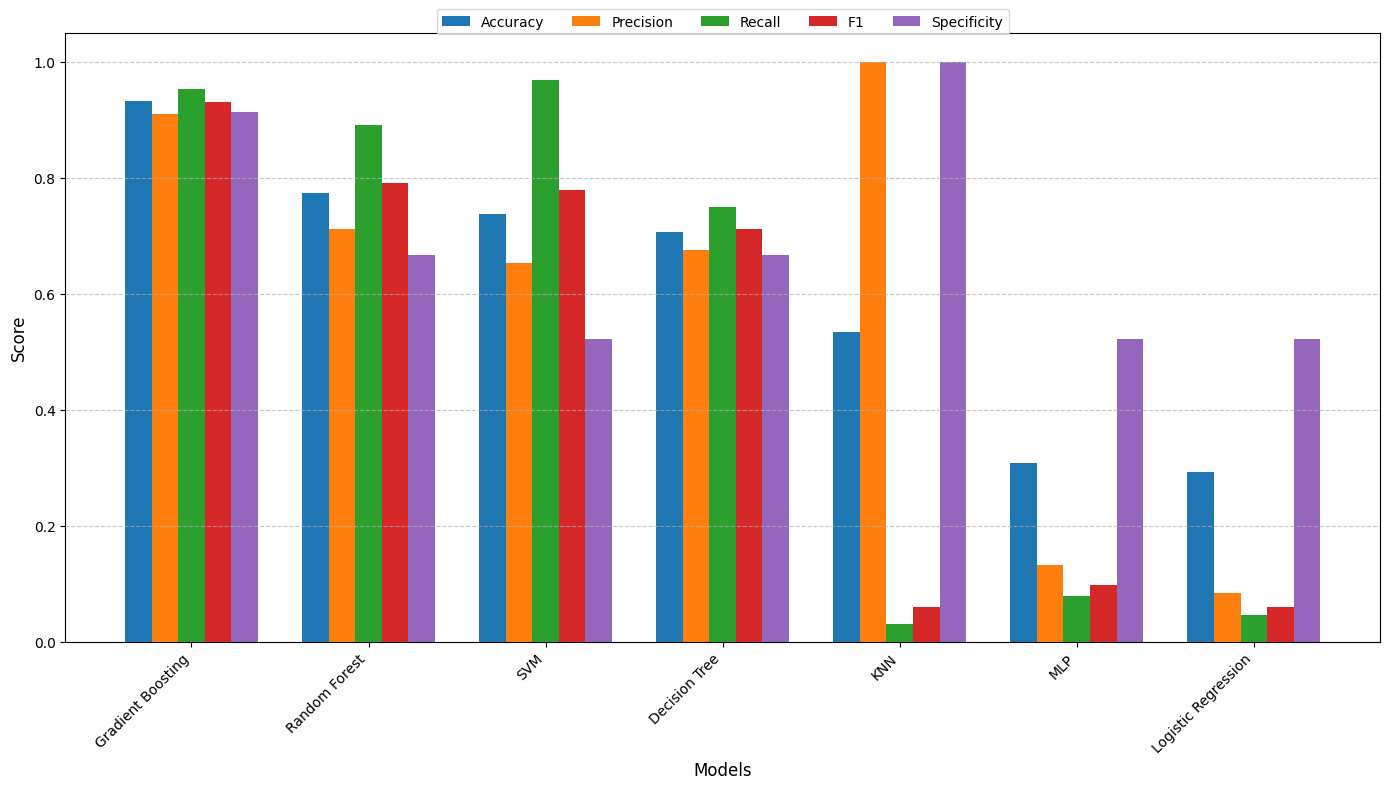

In [18]:
# Create a bar chart comparing performance metrics across all models
plt.figure(figsize=(14, 8))

# Get model names and metrics
models_list = metrics_df['Model'].tolist()
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']

# Set positions and width
x = np.arange(len(models_list))
width = 0.15
multiplier = np.arange(len(metrics_to_plot)) - len(metrics_to_plot)/2 + 0.5

# Plot each metric as a group of bars
for i, metric in enumerate(metrics_to_plot):
    offset = width * multiplier[i]
    plt.bar(x + offset, metrics_df[metric], width, label=metric)

# Add labels, title and legend
plt.xlabel('Models', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('', fontsize=14)
plt.xticks(x, models_list, rotation=45, ha='right')
plt.ylim(0, 1.05)  # Set y-axis from 0 to 1.05
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5)

# Add a grid to make it easier to read values
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()
plt.show()

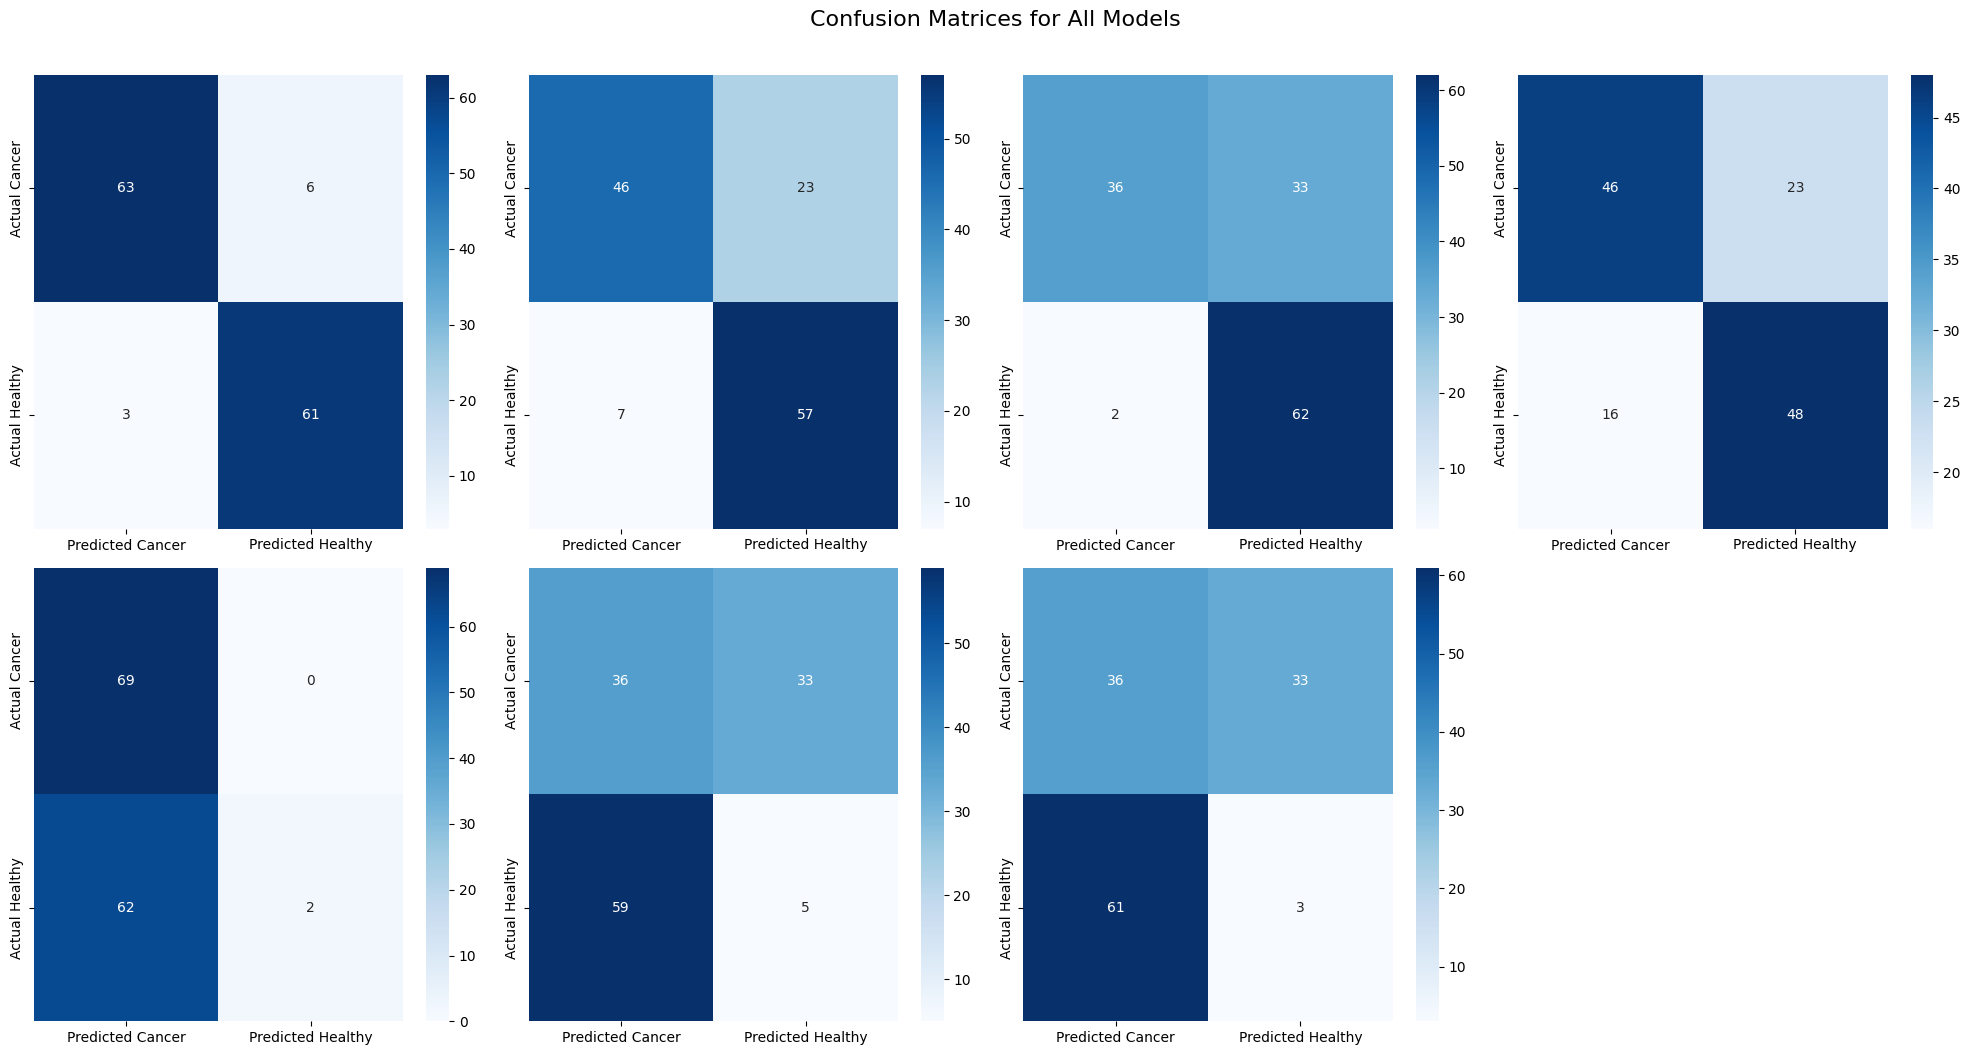

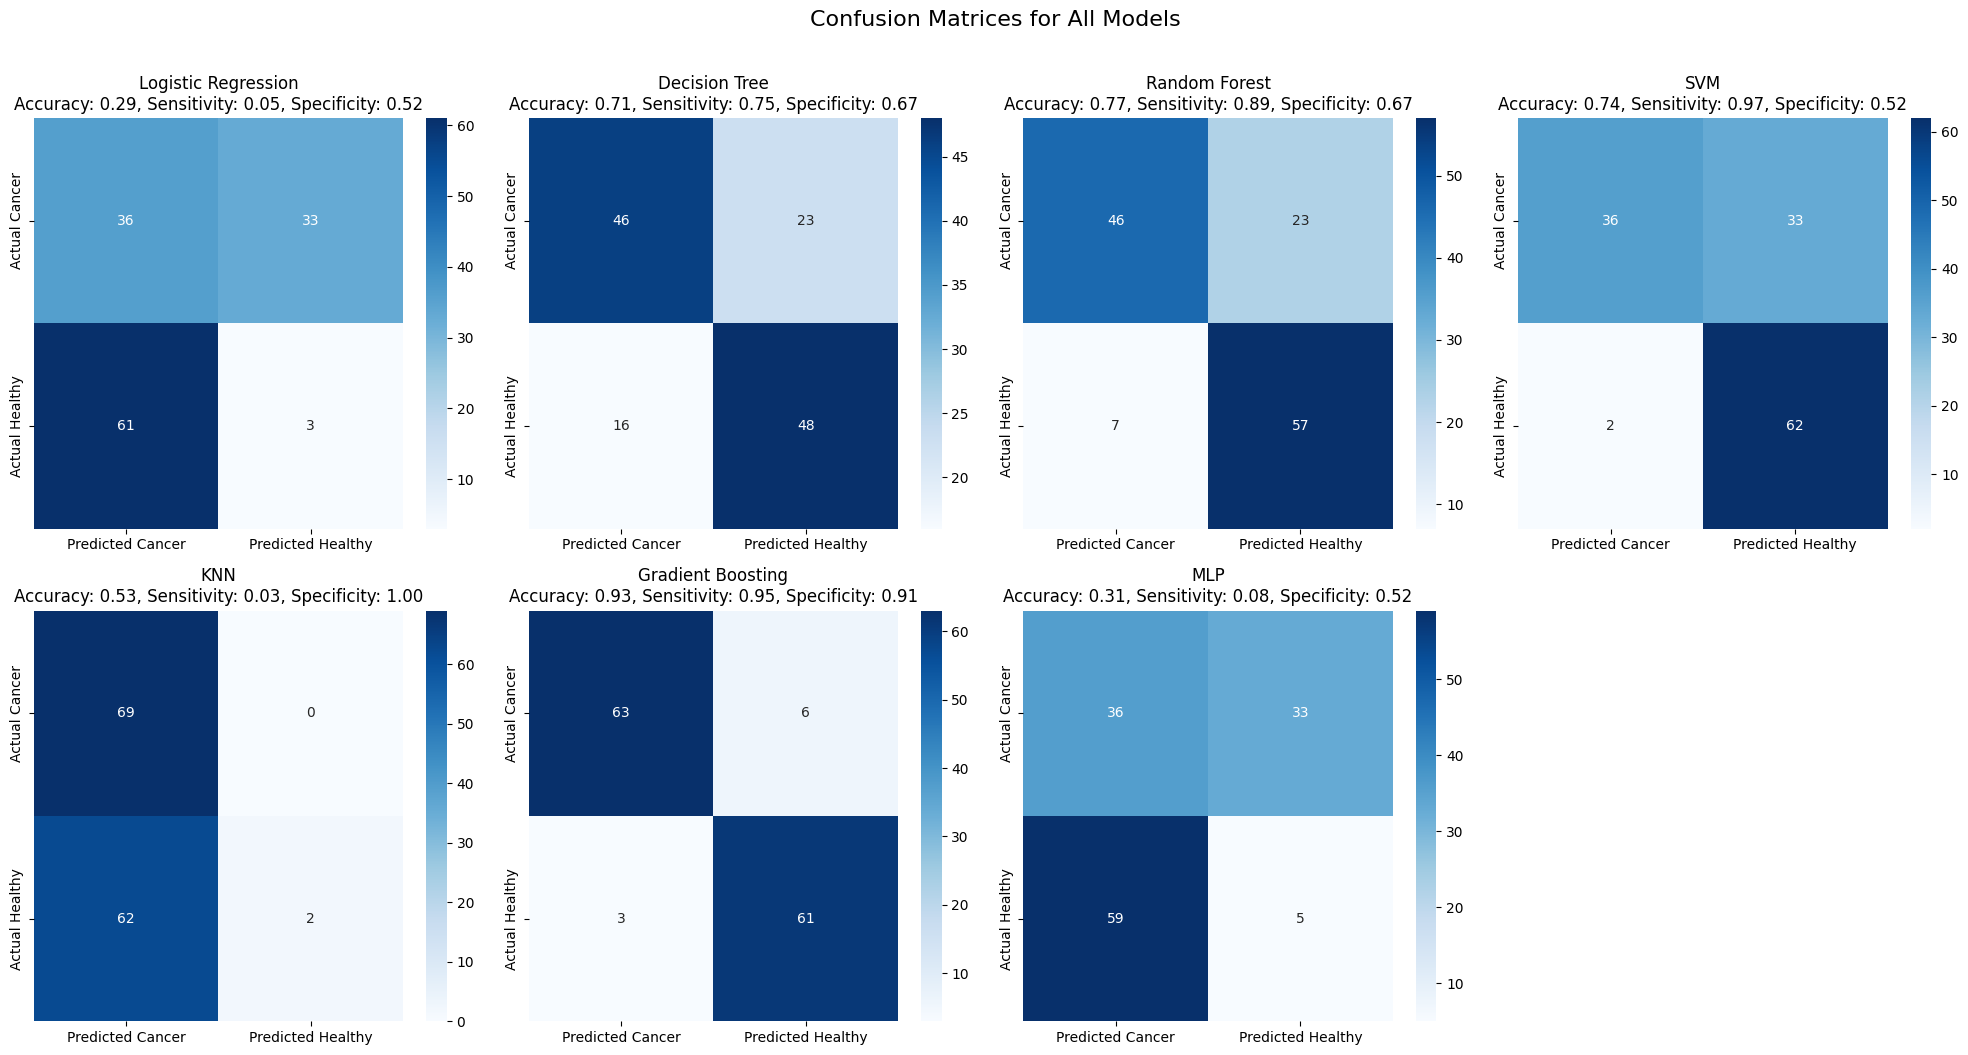

In [22]:
import seaborn as sns

# Create a visualization of confusion matrices for all models

# Get the model names sorted by performance
model_names = metrics_df['Model'].tolist()

# Create confusion matrix for each model
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, name in enumerate(model_names):
    if i < len(axes):  # Make sure we don't exceed available axes
        cm = results[name]['confusion_matrix']
        
        # Plotting the confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Predicted Cancer', 'Predicted Healthy'],
                   yticklabels=['Actual Cancer', 'Actual Healthy'],
                   ax=axes[i])
        
        # Calculate some metrics for title
        tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        # axes[i].set_title(f"{name}\nAccuracy: {accuracy:.2f}, Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}")

# Remove any unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
        
plt.tight_layout()
plt.suptitle('Confusion Matrices for All Models', fontsize=16, y=1.05)
plt.show()
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# Get the model names
model_names = list(results.keys())

# Create confusion matrix for each model
for i, name in enumerate(model_names):
    if i < len(axes):  # Make sure we don't exceed available axes
        cm = results[name]['confusion_matrix']
        
        # Plotting the confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Predicted Cancer', 'Predicted Healthy'],
                   yticklabels=['Actual Cancer', 'Actual Healthy'],
                   ax=axes[i])
        
        # Calculate some metrics for title
        tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        axes[i].set_title(f"{name}\nAccuracy: {accuracy:.2f}, Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}")

# Remove any unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
        
plt.tight_layout()
plt.suptitle('Confusion Matrices for All Models', fontsize=16, y=1.05)
plt.show()

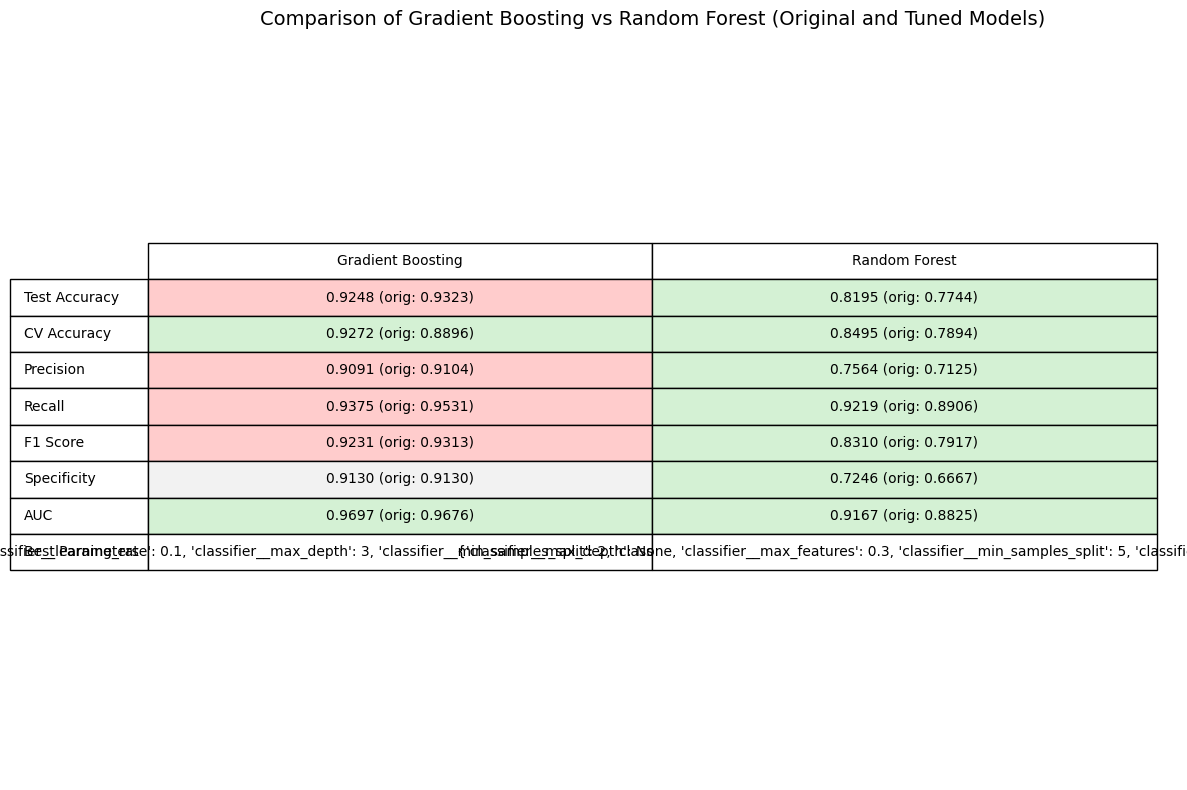

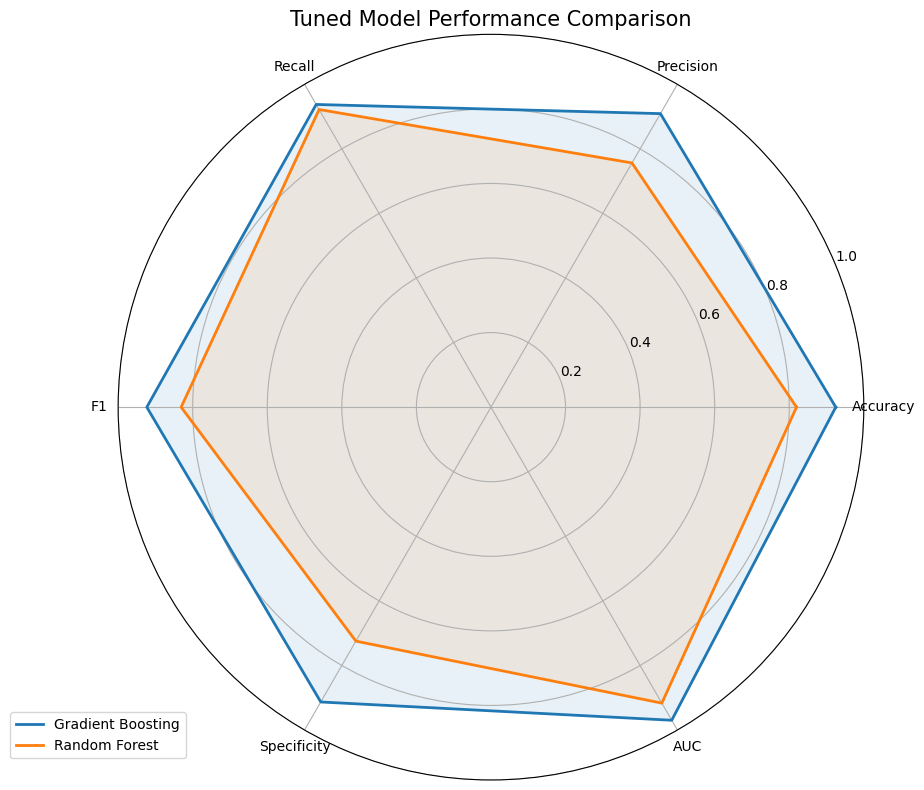

In [20]:
# Create a detailed comparison matrix for the two best models
best_models = ['Gradient Boosting', 'Random Forest']

# Define metrics to compare
metrics_to_compare = [
    'Test Accuracy', 'CV Accuracy', 'Precision', 'Recall', 'F1 Score', 
    'Specificity', 'AUC', 'Best Parameters'
]

# Create a comparative dataframe
comparison_df = pd.DataFrame(index=metrics_to_compare, columns=best_models)

# Fill in the metrics for each model
for name in best_models:
    # Get metrics from original and tuned models
    orig_result = results[name]
    tuned_result = tuning_results[name]
    
    # Calculate metrics from confusion matrix
    orig_cm = orig_result['confusion_matrix']
    tuned_cm = tuned_result['confusion_matrix']
    
    # Original model metrics
    orig_tn, orig_fp, orig_fn, orig_tp = orig_cm[0, 0], orig_cm[0, 1], orig_cm[1, 0], orig_cm[1, 1]
    orig_precision = orig_tp / (orig_tp + orig_fp) if (orig_tp + orig_fp) > 0 else 0
    orig_recall = orig_tp / (orig_tp + orig_fn) if (orig_tp + orig_fn) > 0 else 0
    orig_f1 = 2 * orig_precision * orig_recall / (orig_precision + orig_recall) if (orig_precision + orig_recall) > 0 else 0
    orig_specificity = orig_tn / (orig_tn + orig_fp) if (orig_tn + orig_fp) > 0 else 0
    
    # Tuned model metrics
    tuned_tn, tuned_fp, tuned_fn, tuned_tp = tuned_cm[0, 0], tuned_cm[0, 1], tuned_cm[1, 0], tuned_cm[1, 1]
    tuned_precision = tuned_tp / (tuned_tp + tuned_fp) if (tuned_tp + tuned_fp) > 0 else 0
    tuned_recall = tuned_tp / (tuned_tp + tuned_fn) if (tuned_tp + tuned_fn) > 0 else 0
    tuned_f1 = 2 * tuned_precision * tuned_recall / (tuned_precision + tuned_recall) if (tuned_precision + tuned_recall) > 0 else 0
    tuned_specificity = tuned_tn / (tuned_tn + tuned_fp) if (tuned_tn + tuned_fp) > 0 else 0
    
    # Get AUC values (calculate if not already available)
    pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', models[name])])
    pipeline.fit(X_train, y_train)
    y_score = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    orig_auc = auc(fpr, tpr)
    
    # Get AUC for tuned model
    y_score_tuned = tuned_result['model'].predict_proba(X_test)[:, 1]
    fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_score_tuned)
    tuned_auc = auc(fpr_tuned, tpr_tuned)
    
    # Fill in the comparison dataframe
    comparison_df.loc['Test Accuracy', name] = f"{tuned_result['test_accuracy']:.4f} (orig: {orig_result['test_accuracy']:.4f})"
    comparison_df.loc['CV Accuracy', name] = f"{tuned_result['cv_accuracy']:.4f} (orig: {orig_result['cv_accuracy']:.4f})"
    comparison_df.loc['Precision', name] = f"{tuned_precision:.4f} (orig: {orig_precision:.4f})"
    comparison_df.loc['Recall', name] = f"{tuned_recall:.4f} (orig: {orig_recall:.4f})"
    comparison_df.loc['F1 Score', name] = f"{tuned_f1:.4f} (orig: {orig_f1:.4f})"
    comparison_df.loc['Specificity', name] = f"{tuned_specificity:.4f} (orig: {orig_specificity:.4f})"
    comparison_df.loc['AUC', name] = f"{tuned_auc:.4f} (orig: {orig_auc:.4f})"
    comparison_df.loc['Best Parameters', name] = str(tuned_result['best_params'])

# Display the comparison matrix
plt.figure(figsize=(12, 8))
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Create a colorful table
table = plt.table(
    cellText=comparison_df.values,
    rowLabels=comparison_df.index,
    colLabels=comparison_df.columns,
    cellLoc='center',
    loc='center',
    colWidths=[0.4, 0.4]
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.8)

# Color code cells based on performance improvement
for i in range(len(metrics_to_compare) - 1):  # Skip the parameters row
    for j, name in enumerate(best_models):
        cell = table[(i+1, j)]
        # Check if there's improvement in tuned vs original model
        if 'orig' in comparison_df.iloc[i, j]:
            # Extract values for comparison
            value_str = comparison_df.iloc[i, j]
            tuned_val = float(value_str.split(" (orig")[0])
            orig_val = float(value_str.split("orig: ")[1].rstrip(")"))
            
            if tuned_val > orig_val:
                cell.set_facecolor('#d4f1d4')  # Light green for improvement
            elif tuned_val < orig_val:
                cell.set_facecolor('#ffcccc')  # Light red for decline
            else:
                cell.set_facecolor('#f2f2f2')  # Light gray for no change

plt.title('Comparison of Gradient Boosting vs Random Forest (Original and Tuned Models)', fontsize=14)
plt.tight_layout()
plt.show()

# Also create a radar chart comparing the tuned models on key metrics
metrics_for_radar = ['Accuracy', 'Precision', 'Recall', 'F1', 'Specificity', 'AUC']
num_metrics = len(metrics_for_radar)

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
angles = np.linspace(0, 2*np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]  # Close the polygon

# Extract metrics values for radar chart
values = {}
for name in best_models:
    cm = tuning_results[name]['model'].predict(X_test)
    cm = confusion_matrix(y_test, cm)
    
    tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    y_score = tuning_results[name]['model'].predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Store values
    values[name] = [accuracy, precision, recall, f1, specificity, roc_auc]
    values[name] += values[name][:1]  # Close the polygon
    
    # Plot
    ax.plot(angles, values[name], linewidth=2, linestyle='solid', label=name)
    ax.fill(angles, values[name], alpha=0.1)

# Customize the chart
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_for_radar)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
ax.set_ylim(0, 1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Tuned Model Performance Comparison', size=15)
plt.tight_layout()
plt.show()